# Amazon Simple Storage Service (S3) Tutorial

In this tutorial, we describe the paths supported by the public S3 bucket. We also make an example query to the container to get asteroid data for (705) Erminia. With this data, we show how to make a light curve.

## Install requirements

To begin, users can optionally create a python virtual enviroment and install the following requirements in the root of the directory:

```python
pip install -r requirements.txt
```

## Import relevant libraries

To begin, we want to import the necessary libraries for the bucket to be used correctly. Note that users will have to install additional dependencies as part of the `astropy` package. Specifically, users will need `fsspec` and `s3fs` to be able to correctly access the S3 bucket via `astropy` commands (see [Extracting via `astroquery`](#extracting-via-astroquery)). Users can look at the __[installing `astropy`](https://docs.astropy.org/en/stable/install.html#installing-astropy)__ directions for more details. Alternatively, users can import `fsspec` and `pip install s3fs` (see [Extracting via direct installation of `fsspec` and `s3fs`](#extracting-via-direct-installation-of-fsspec-and-s3fs)).

In [1]:
# import libraries
import fsspec # optional depending on the astropy dependencies installed
import matplotlib.pyplot as plt
import seaborn as sns

from astropy.visualization import astropy_mpl_style
from astropy.io import fits

plt.style.use(astropy_mpl_style)
sns.set_theme(style='ticks')
%matplotlib inline

## Request and extract data

Next, we want to make a call to the bucket. This call will always be in the form of a path containing relevant parameters. In this example, we are making a call to the S3 path, which will return a `.FITS` file containing data to generate a light curve. The data that are returned include the flux (mJy), flux error (mJy), normalization factors, and time of observation (unix). The general format for this query is `s3://cornell-acteroids/asteroid_lc_array_frequency.fits`. The parameters to change are `asteroid`, `array`, and `frequency`. 

By loading in this file, we can extract data by calling the relevant column names from the `.FITS` file header. Here, we collect the time of observation, flux from each measurement, and flux error. In this example, we are collecting data for the asteroid (705) Erminia on ACT array pa6 at 90 GHz. 

As part of the data products, we provide the asteroid weighting calculation for each asteroid. This weighting is based on the Rayleigh-Jeans approximation for the __[Standard Thermal Model](https://www.sciencedirect.com/science/article/pii/0019103586900217?via%3Dihub)__ and considers the earth-asteroid distance as well as the earth-asteroid-sun angle. 

The only parameters users need to change are `asteroid`, `array`, and `frequency`. For this example, we collect data for (705) Erminia on ACT array pa6 at a frequency of 90 GHz.

In [2]:
# create request to ACTeroids container
asteroid = 'Erminia'
array = 'pa4'
frequency = '150'

Once the user selects these three parameters, obtaining the data is a matter of creating the correct S3 path and extracting the relevant data, as one would for a `.FITS` file. The code below does not need to be modified in any way.

In [3]:
name = '{}_lc_{}_{}'.format(asteroid, array, frequency) # this is the final format of the string

s3_path = 's3://cornell-acteroids/' + name + '.fits'

Extracting data is slight different depending on the installation procedure. See [Extracting via `astroquery`](#extracting-via-astroquery) when the `fsspec` and `s3fs` libraries are installed along with astropy. Otherwise, see [Extracting via direct installation of `fsspec` and `s3fs`](#extracting-via-direct-installation-of-fsspec-and-s3fs) for those doing direct installation of these two packages.

### Extracting via `astroquery`

Below lies code for installing the `fsspec` and `s3fs` libraries via `astroquery`.

In [4]:
with fits.open(s3_path, fsspec_kwargs={"anon": True}) as hdul:  
    data = hdul[1].data

### Extracting via direct installation of `fsspec` and `s3fs`

If users decide instead to `import fsspec` and `pip install s3fs`, then the following code should be used to open data from AWS.

In [5]:
with fsspec.open(s3_path, 'rb', anon=True) as fileobj:
    with fits.open(fileobj) as hdul:
        data = hdul[1].data

Once data are collected, then data from the columns can be collected as follows.

In [9]:
# get data from each column
times = data['Time']
flux = data['Flux']
error = data['FluxUncertainty']
weight = data['Weight']

## Light curves

To make light curves, we take the times, flux, and error bars and create a scatter plot. 

We discourage users from binning data over time, since there will be unwanted correlated errors.

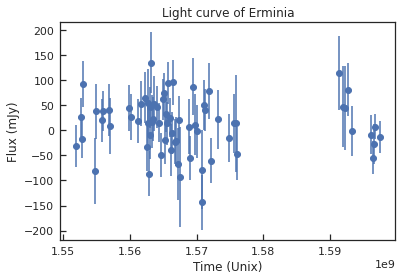

In [7]:
# create and display scatter plot with error bars
plt.errorbar(times, flux, yerr=error, fmt='o')
plt.tick_params(direction='in')
plt.title('Light curve of {}'.format(asteroid))
plt.xlabel('Time (Unix)')
plt.ylabel('Flux (mJy)')
plt.savefig('Erminia_lcurve.pdf')
plt.show()

## References

For more information about this data set, see [John Orlowski-Scherer et al 2024 ApJ 964 138](https://iopscience.iop.org/article/10.3847/1538-4357/ad21fe/meta).